In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Load CSV
df = pd.read_csv("Food_Delivery_Times.csv")

In [10]:
# Drop irrelevant columns
if 'Order_ID' in df.columns:
    df = df.drop(columns=['Order_ID'])

In [11]:
# Remove duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
df = df.drop_duplicates().reset_index(drop=True)

print("\nINFO after dropping duplicates:")
print(df.info())

Number of duplicate rows: 0

INFO after dropping duplicates:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Weather                 970 non-null    object 
 2   Traffic_Level           970 non-null    object 
 3   Time_of_Day             970 non-null    object 
 4   Vehicle_Type            1000 non-null   object 
 5   Preparation_Time_min    1000 non-null   int64  
 6   Courier_Experience_yrs  970 non-null    float64
 7   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB
None


In [12]:
# 2. Data Cleaning & Preprocessing
# Convert to category
categorical_columns = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

print("\nINFO after converting categorical columns:")
print(df.info())

# Describe dataset
print("\nSummary statistics (numeric & categorical):")
print(df.describe(include='all'))


INFO after converting categorical columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Distance_km             1000 non-null   float64 
 1   Weather                 970 non-null    category
 2   Traffic_Level           970 non-null    category
 3   Time_of_Day             970 non-null    category
 4   Vehicle_Type            1000 non-null   category
 5   Preparation_Time_min    1000 non-null   int64   
 6   Courier_Experience_yrs  970 non-null    float64 
 7   Delivery_Time_min       1000 non-null   int64   
dtypes: category(4), float64(2), int64(2)
memory usage: 35.9 KB
None

Summary statistics (numeric & categorical):
        Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
count   1000.000000     970           970         970         1000   
unique          NaN       5             3           4    


 Value Counts for Categorical Columns:

Weather:
 Weather
Clear    470
Rainy    204
Foggy    103
Snowy     97
Windy     96
Name: count, dtype: int64

Traffic_Level:
 Traffic_Level
Medium    390
Low       383
High      197
Name: count, dtype: int64

Time_of_Day:
 Time_of_Day
Morning      308
Evening      293
Afternoon    284
Night         85
Name: count, dtype: int64

Vehicle_Type:
 Vehicle_Type
Bike       503
Scooter    302
Car        195
Name: count, dtype: int64


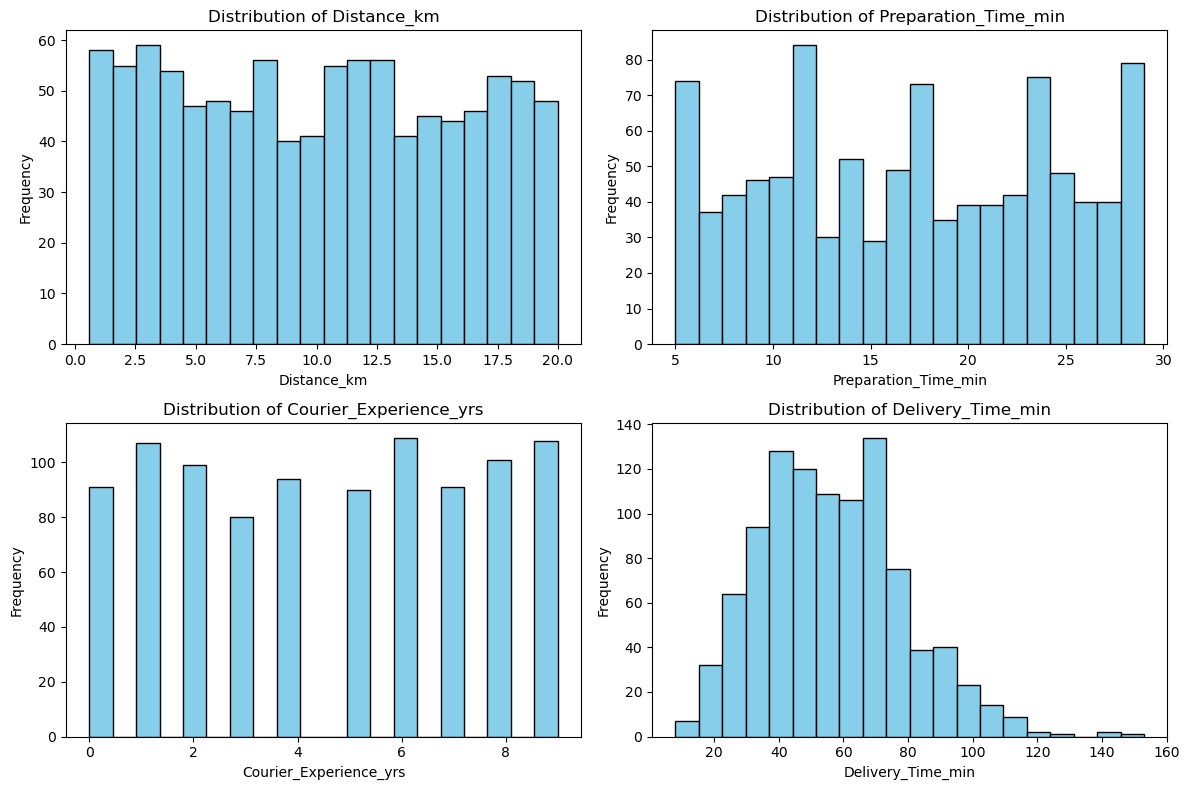

In [13]:
# 3. EDA
# Value counts
print("\n Value Counts for Categorical Columns:")
for col in categorical_columns:
    print(f"\n{col}:\n", df[col].value_counts())

# Histograms for numeric columns
numeric_columns = ['Distance_km', 'Preparation_Time_min',
                   'Courier_Experience_yrs', 'Delivery_Time_min']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

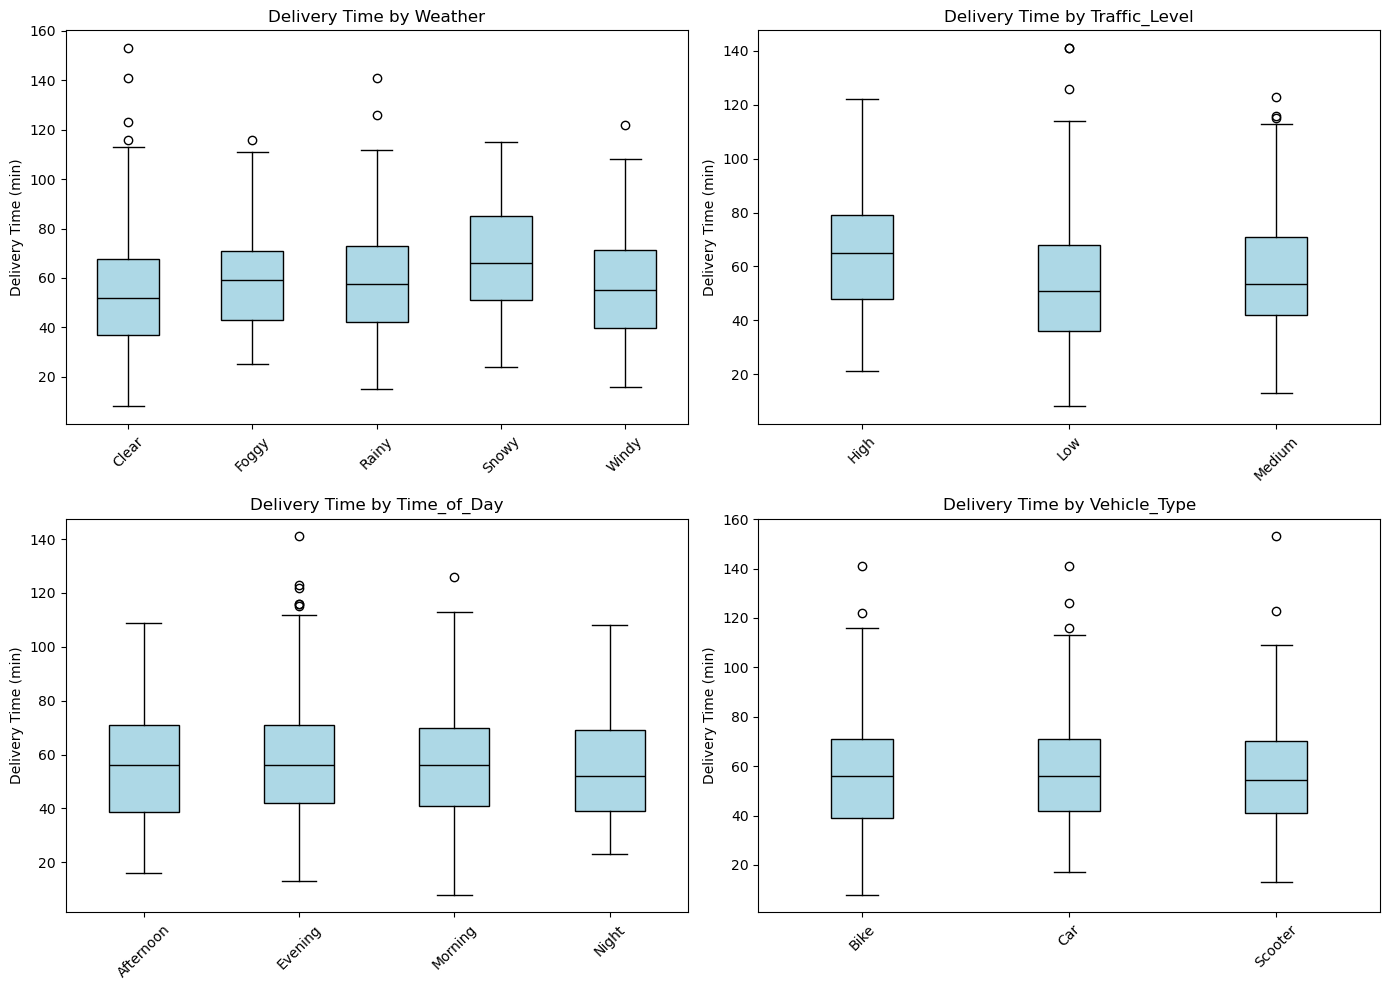

In [15]:
# Boxplots for delivery time by categorical variables
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    categories = df[col].cat.categories
    data = [df[df[col] == cat]['Delivery_Time_min'] for cat in categories]
    plt.boxplot(data, labels=categories, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='black'))
    plt.title(f'Delivery Time by {col}')
    plt.ylabel("Delivery Time (min)")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\pavit\AppData\Local\Temp\ipykernel_8128\568845159.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(col)['Delivery_Time_min']
C:\Users\pavit\AppData\Local\Temp\ipykernel_8128\568845159.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(col)['Delivery_Time_min']
C:\Users\pavit\AppData\Local\Temp\ipykernel_8128\568845159.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g

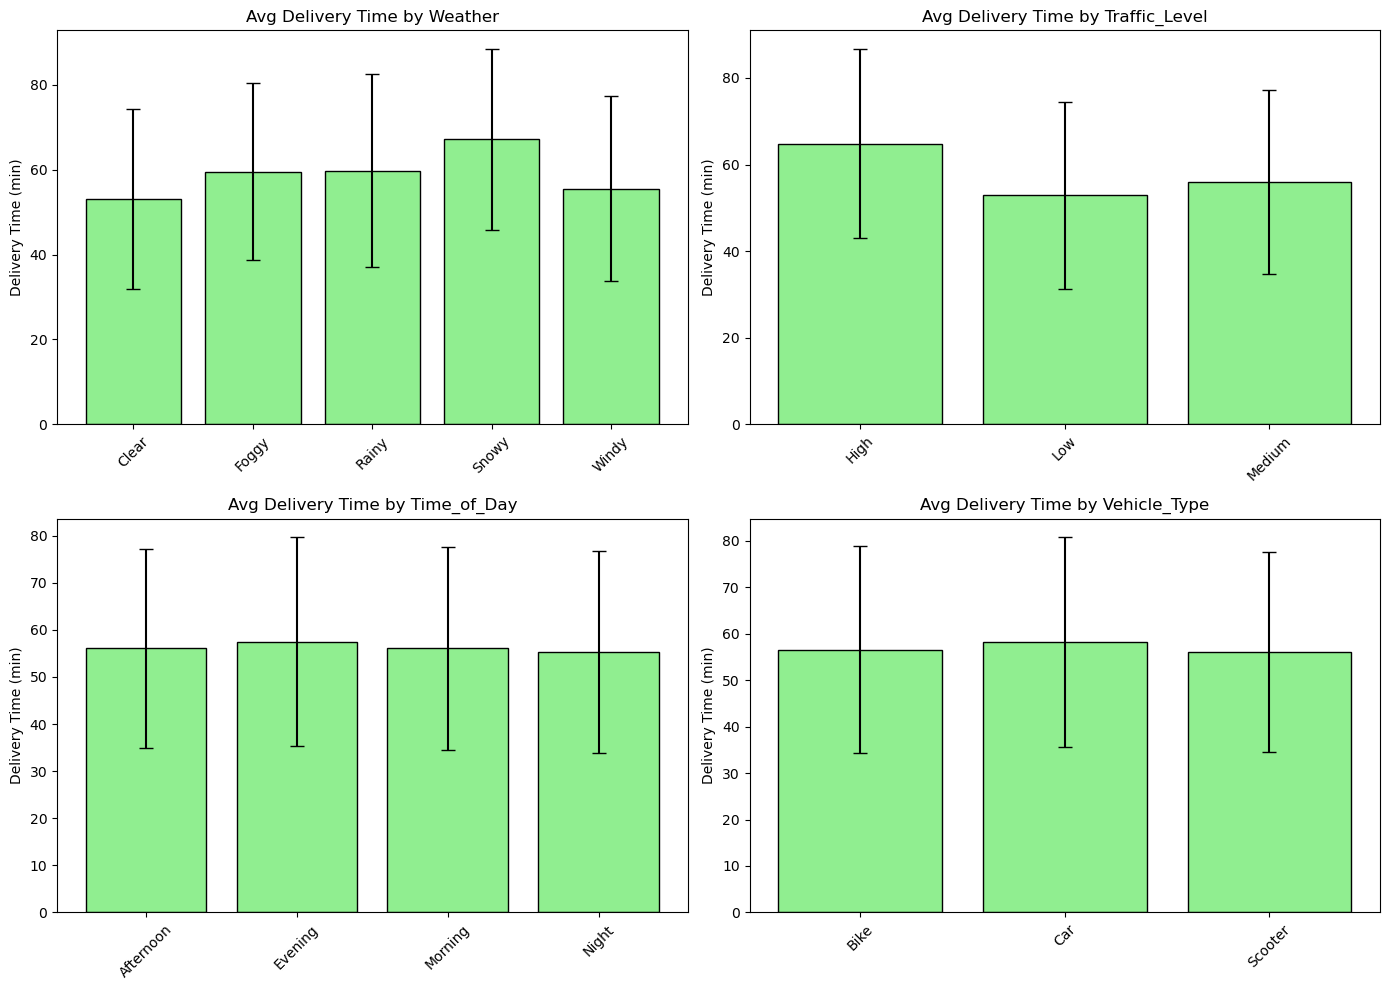

In [16]:
# Average delivery time by category
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    group = df.groupby(col)['Delivery_Time_min']
    mean = group.mean()
    std = group.std()
    plt.bar(mean.index.astype(str), mean.values, yerr=std.values,
            capsize=5, color='lightgreen', edgecolor='black')
    plt.title(f'Avg Delivery Time by {col}')
    plt.ylabel('Delivery Time (min)')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

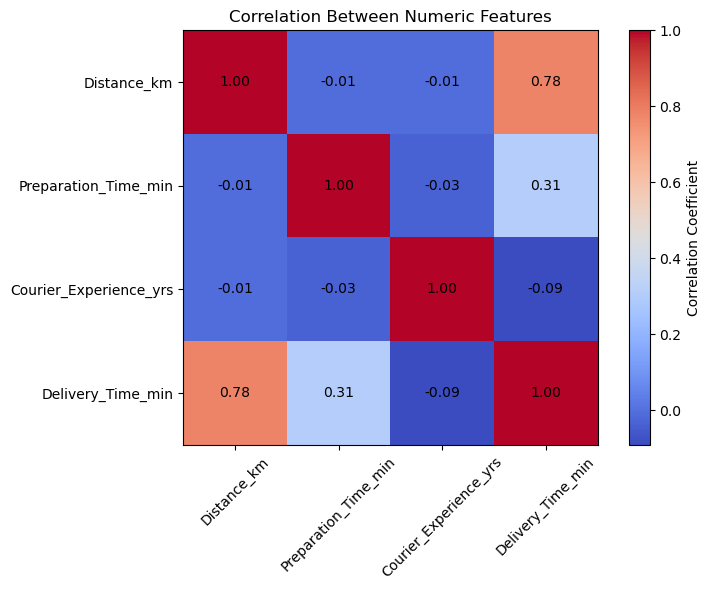

In [17]:
# Correlation heatmap
corr_matrix = df[numeric_columns].corr().values
labels = numeric_columns

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')
plt.title("Correlation Between Numeric Features")
plt.tight_layout()
plt.show()

In [18]:
# 4. Prepare data for Modeling
target_column = 'Delivery_Time_min'

# Features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Check for NaNs
print("\n Checking for NaNs in features after encoding:")
print(X_encoded.isnull().sum())

# Fill any NaNs with zero
X_encoded = X_encoded.fillna(0)

# Check target
print("\n Checking for NaNs in target:")
print(y.isnull().sum())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("\n Data prepared for modeling.")
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])



 Checking for NaNs in features after encoding:
Distance_km                0
Preparation_Time_min       0
Courier_Experience_yrs    30
Weather_Foggy              0
Weather_Rainy              0
Weather_Snowy              0
Weather_Windy              0
Traffic_Level_Low          0
Traffic_Level_Medium       0
Time_of_Day_Evening        0
Time_of_Day_Morning        0
Time_of_Day_Night          0
Vehicle_Type_Car           0
Vehicle_Type_Scooter       0
dtype: int64

 Checking for NaNs in target:
0

 Data prepared for modeling.
Training samples: 800
Test samples: 200


In [20]:
# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("\nLinear Regression Results:")
print("Mean Squared Error:", mse_lin)
print("R2 Score:", r2_lin)




Linear Regression Results:
Mean Squared Error: 78.79248568989709
R2 Score: 0.8242129767181079



Random Forest Regression Results:
Mean Squared Error: 107.2300135
R2 Score: 0.7607684956935044

Random Forest Feature Importances:
                  Feature  Importance
0             Distance_km    0.699268
1    Preparation_Time_min    0.158644
2  Courier_Experience_yrs    0.042815
7       Traffic_Level_Low    0.019129
9     Time_of_Day_Evening    0.011712


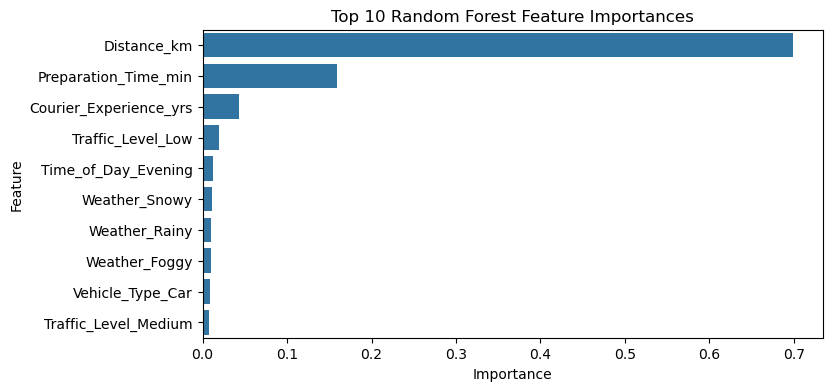

In [25]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression Results:")
print("Mean Squared Error:", mse_rf)
print("R2 Score:", r2_rf)

# Feature importances
importances_rf = rf_model.feature_importances_
features_rf = X_encoded.columns
feature_importance_rf = pd.DataFrame({
    'Feature': features_rf,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(feature_importance_rf.head())

# Plot feature importance
plt.figure(figsize=(8, 4))
sns.barplot(
    data=feature_importance_rf.head(10),
    x='Importance',
    y='Feature'
)
plt.title("Top 10 Random Forest Feature Importances")
plt.show()



XGBoost Regression Results:
Mean Squared Error: 91.14122943026776
R2 Score: 0.7966627746349542


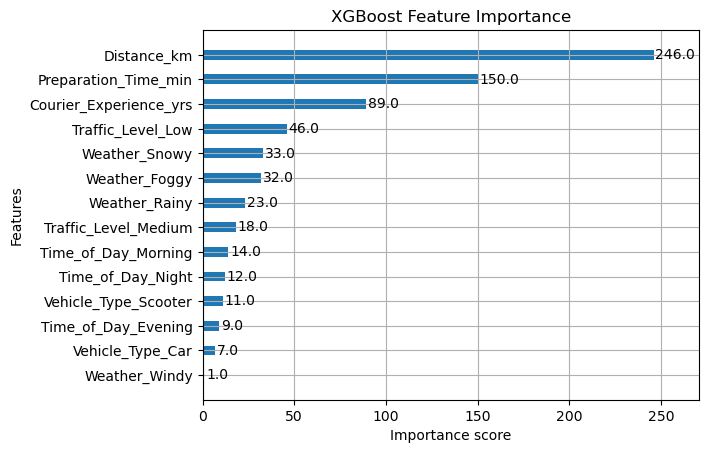

In [27]:
# XGBoost Regression
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Results:")
print("Mean Squared Error:", mse_xgb)
print("R2 Score:", r2_xgb)

# Plot XGBoost feature importance
xgb.plot_importance(xgb_model, importance_type='weight', height=0.4)
plt.title("XGBoost Feature Importance")
plt.show()

In [28]:
# Compare all Models
print("\n Model Comparison Summary")
summary = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "MSE": [mse_lin, mse_rf, mse_xgb],
    "R2 Score": [r2_lin, r2_rf, r2_xgb]
})
print(summary)


 Model Comparison Summary
               Model         MSE  R2 Score
0  Linear Regression   78.792486  0.824213
1      Random Forest  107.230013  0.760768
2            XGBoost   91.141229  0.796663
